# **Montecarlo**
----

## Goals of this notebook:

1. Make sure that the most basic environment (HitStand) properly works.
2. Deploy main plotting utilities.
3. Execute a simple experiment to make sure that my hand-made Montecarlo-based algorithms (for both prediction and control) are mistake proof.
4. Define methods to accelerate multiple episode executions in later notebooks.
5. Showcase agents' common efficiency-oriented capabilities (e.g.: Q/V-table storage and agent storage).

---
## Library imports

#### 1. RL libraries:

In [34]:
import environments
from agents.agents import MonteCarloPredictor, MontecarloController, OffPolicyMontecarlo

#### 2. Data aggregation and matrix operation libraries:

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

#### 3. Plotting libraries:

In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

#### 4. Statistical analysis tools:

In [37]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest, anderson, t, kstest

----

## Common plotting utilities:

#### Average reward time series:

In [38]:
def plot_reward_time_series(X,Y):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically (more episodes => more x-ticks)
    max_domain = X[-1]
    domain = np.arange(X[0], max_domain + X[0] * 100, X[0] * 100)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (0, max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': (-1, 1),
                  'yticks': np.arange(-1, 1.1, 0.05),
                  'yticklabels': np.arange(-1, 1.1, 0.05),
                  'title': 'Average reward over last {0} episodes'.format(str(X[0]))
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter()
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    ax.plot(X,Y)
    return ax

#### Density plot:

In [77]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average reward
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.2f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'.format(data.mean(),
                                                                                                                     data.std(),
                                                                                                                     data.index.values[0],
                                                                                                                     len(data))
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20)
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [70]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, that must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [40]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must be n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

---

## Statistical functions:

I use an **alpha value of 5%** for any statistical test executed in this project

In [41]:
CONFIDENCE_STRING_FORMAT = '5%'
CONFIDENCE = 0.05

In [42]:
def dickey_fuller(time_series, confidence=CONFIDENCE_STRING_FORMAT):
    fuller_results = adfuller(results)
    if fuller_results[0] < fuller_results[4][confidence]:
        return 'Null hypothesis can be rejected. The series is stationary.'
    else:
        return 'Null hypothesis cannot be rejected. The series is not stationary'

----

## Basic enviroment presentation:

In [43]:
# AI gym-like enviroment instance creation:
env = environments.make('hitstand')

In [44]:
print(env)
# Main rules:

1. 6 decks (with replacement after each episode)
2. Dealer stands on soft 17
3. No Double Down
4. No split
5. No insurance offered
6. No surrender
7. Natural Blackjack 3:2


**Code note**: although natural Blackjack triggers a 3:2 payoff, it will never be computed as Blackjack states entail automatic state transition (the agent receives two cards and just needs to wait for hand resolution).  

In [45]:
env.reward_space_description

{-1: 'The House beats Jack',
 0: 'Draw/not terminal',
 1: 'Jack beats the House',
 1.5: 'Blackjack for Jack'}

In [46]:
env.observation_space_description
# Every observation consists of a 3-element tuple, the description for each element and their positions are:

{0: "Player's total", 1: "Dealer's card value", 2: 'Player has got usable ace'}

A "usable ace" means the ace value is 11, instead of 1.

In [47]:
'Observation space ranges from {0} to {1}'.format(env.observation_space_low, env.observation_space_high)

'Observation space ranges from [4 2 0] to [30 26  1]'

**Comments on the observation space definition**:

- Lower bounds: Player's total value is bounded from below at 4, as any potential smaller value would imply the use of an ace (and its value is 11 at the start of the hand); Dealer's is bounded from below at 2, as he/she is only handed in one card initially.

- Upper bounds: those reach the maximum value a player/dealer might obtain. However, any state that goes over 21 is not computationally taken into account; they are terminal states and final reward is associated to both the last executed action and the state from which transition to terminal state is taking place. Therefore, the Q/V-table values for terminal states remain 0 over the whole experiments.

- Player has got usable ace: a binary encoding is used to indicate whether or not the player has got a usable ace (0=False, 1=True).

----

## Experiment Definition:

In [48]:
def run_experiment(environment, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text.
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistance at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed during the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

---

## Agent Deployments

### 1. Montecarlo Prediction:

The agent assesses a policy and estimates its value. There is no learning.

I use **every visit** Montecarlo. For the problem at hand, there is no difference between first visit and every visit MC, because the likelihood to visit the same state in the same episode is 0%: the agent only retains the same value after obtaining a combination of ace and a card between 2 and 9, then hitting and receiving a 10-point card. However, that triggers a transition from a usable-ace state to a non-usable-ace state.

**Code note**: agent classes must be subclassed before instantion, so that the not implemented "follow_policy" method is overriden. This is the idea I have come up with to define policies for a given agent, what in turn enforces a 'one-agent-one policy' strategy.

In [49]:
class Deterministic(MonteCarloPredictor):
    
    def follow_policy(self, observation, *args):
        #if your cards add up to a number greater than 17, stand; otherwise, hit:
        if observation[0] > 17:
            return 0
        else:
            return 1

In [50]:
deterministic_agent = Deterministic(env)
# Environment instance is passed as an argument; it helps define a proper size for V/Q-table based on the environment's features.

In [51]:
deterministic_agent.hyperparams
# The agent has the following default parameters:

{'discount_rate': 1, 'learning_rate': None}

**Code note**:
If **learning rate** value is set to None, it means that the learning rate is defined as $\frac{1}{t}$ (where $t$ is the number of times a state has been visited). It is the default way to push the average towards its true value incrementally and it satisfies the Robbins-Monro conditions:

$$\sum_{t=0}^{\infty}\frac{1}{t} = \infty$$
$$\sum_{t=0}^{\infty}\frac{1}{t^2} < \infty$$


#### **First experiment following a deterministic policy:**

In [52]:
EPISODES = 10_000
SHOW_EVERY = 1_000
SAVE_EVERY =  None
#I choose an arbitrary sample size for the purpose of this notebook. I will discuss a more convenient value later.
COLLECT_EVERY = 50
results = run_experiment(env, deterministic_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 1000:
Jack:
	-Cards: ['4S', 'KS']
	-Value : 14
Dealer:
	-Cards: ['QC']
	-Value : 10
Jack decides to: HIT
	-Cards: ['4S', 'KS', '4H']
	-Value : 18
Jack decides to: STAND
	-Cards: ['4S', 'KS', '4H']
	-Value : 18
Dealer:
	-Cards: ['QC', '8C']
	-Value : 18
DRAW
Episode 2000:
Jack:
	-Cards: ['7H', '2S']
	-Value : 9
Dealer:
	-Cards: ['7C']
	-Value : 7
Jack decides to: HIT
	-Cards: ['7H', '2S', '10C']
	-Value : 19
Jack decides to: STAND
	-Cards: ['7H', '2S', '10C']
	-Value : 19
Dealer:
	-Cards: ['7C', '3S', '2D', '6D']
	-Value : 18
JACK BEATS THE HOUSE
Episode 3000:
Jack:
	-Cards: ['AD', '8C']
	-Value : 19
Dealer:
	-Cards: ['4H']
	-Value : 4
Jack decides to: STAND
	-Cards: ['AD', '8C']
	-Value : 19
Dealer:
	-Cards: ['4H', '4C', 'JH']
	-Value : 18
JACK BEATS THE HOUSE
Episode 4000:
Jack:
	-Cards: ['8H', '4D']
	-Value : 12
Dealer:
	-Cards: ['3D']
	-Value : 3
Jack decides to: HIT
	-Cards: ['8H', '4D', '8C']
	-Value : 20
Jack decides to: STAND
	-Cards: ['8H', '4D', '8C']
	-Value : 20
Deal

**Average reward** is the main metric I use to measure how well an agent fares when attempting to learn. So it is worth succintly showing some of the tools I am hereafter using to track the metric:

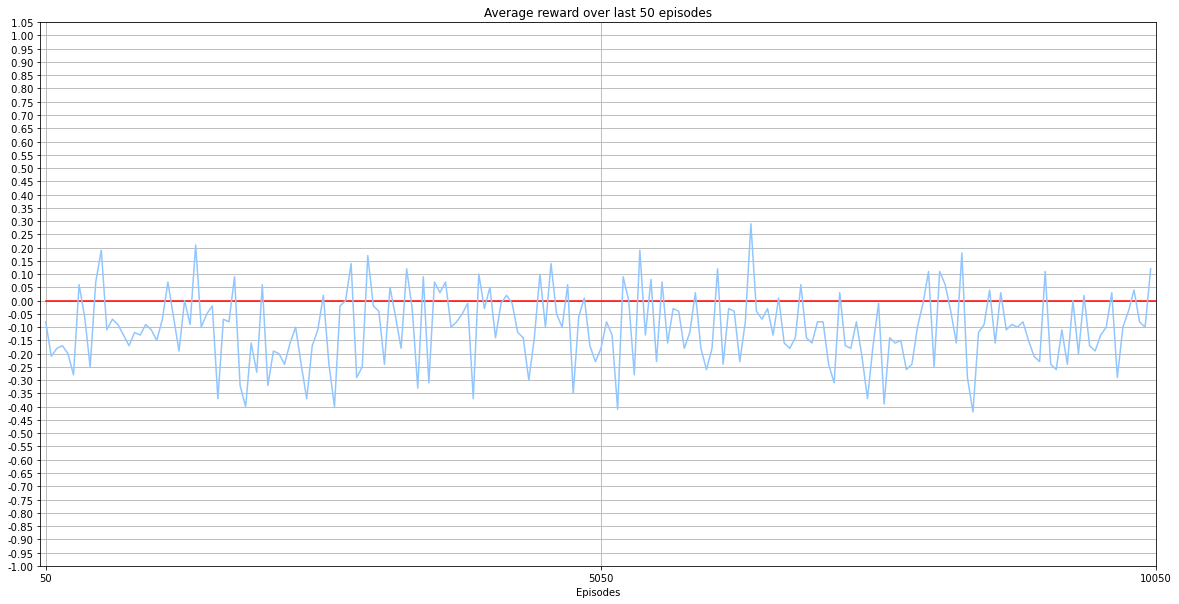

In [53]:
#Calling one of the above-mentioned plotting functions:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

#### **Learning proof**:
The agent is not learning, since prediction implies the evaluation of a given policy. However, I would like to take the opportunity to state the method I am hereafter using to prove the existence of learning:

**Augmented Dickey-Fuller test:**

I am assuming that the average reward time series is stationary (same average and same variance for the whole time series) when there is no learning. Therefore, Augmented Dickey-Fuller is fit for purpose. It tests the null hypothesis that the series is **not** stationary.

In [54]:
dickey_fuller(results)

'Null hypothesis can be rejected. The series is stationary.'

Since card games entail stochasticity (at least, the randomness of withdrawing certain cards from a deck (which implicitly affects the probability of transitioning from one state to another)), it is necessary to set the statistical ground for analysing confidence intervals for average rewards. 

In [55]:
# Short statistical analysis:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    200.000000
mean      -0.102350
std        0.137654
min       -0.420000
25%       -0.182500
50%       -0.100000
75%       -0.010000
max        0.290000
dtype: float64

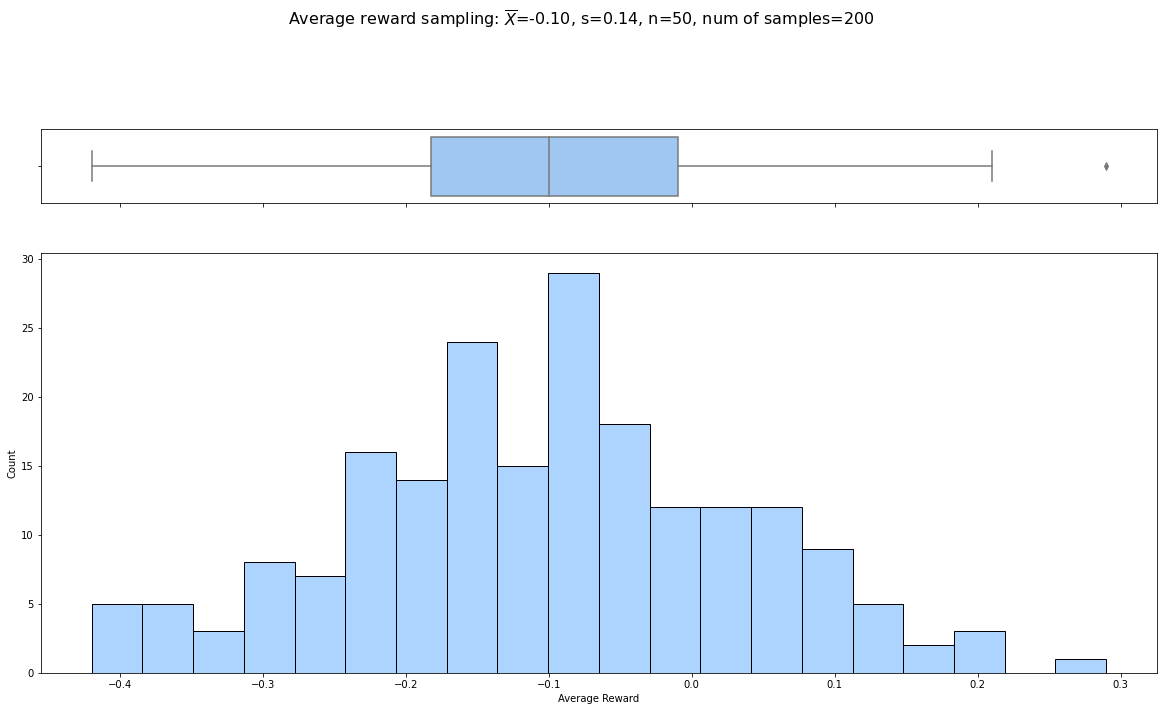

In [78]:
plot_density(runs);

On the other hand, it is necessary to evaluate how 'good' falling in a given non-terminal state is. In such case, I proceeed as follows:

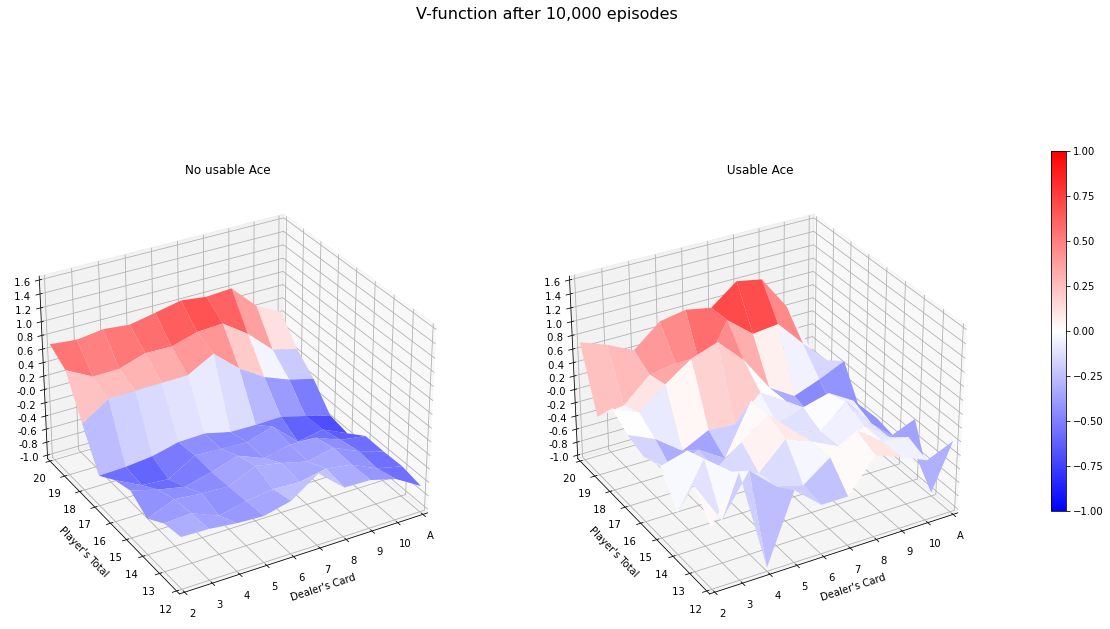

In [79]:
plot_v_func(deterministic_agent.table, 'V-function after {:,.0f} episodes'.format(EPISODES));

**Second Experiment using a stochastic policy (to show how to persist agent's information during experiments)**

In [81]:
#Subclassing to furnish a policy for the stochastic agent.
class Stochastic(MonteCarloPredictor):
    
    #MonteCarloPredictor class generates a V-table by default. For this case, it is necessary to use a q-table: every action can be choosen with a
    #certain probability in every state, so that the expected value in a given state can be different for every possible action
    def __init__(self, env, table_type='q'):
        super().__init__(env, table_type)
        
    def follow_policy(self, observation, *args):
        # if my total points add up to a number greater than 15, I choose to stand with prob 0.9 and hit with prob 0.1; otherwise, I choose to hit
        #with prob 0.9 and stand with prob 0.1
        if observation[0] > 15:
            action = np.random.choice((0,1), p=(0.9, 0.1))
        else:
            action = np.random.choice((0,1), p=(0.1,0.9))

        return action
    

In [88]:
stochastic_agent = Stochastic(env)

In [89]:
#Every agent has a unique id that help manage information persistence and its posterior retrieval:
stochastic_agent.id

'dcfbf44f5b9b49b38553a5474f9b1503'

In [90]:
EPISODES = 100_000
SHOW_EVERY = 10_000
#I save the q-table
SAVE_EVERY =  10_000
COLLECT_EVERY = 50
results = run_experiment(env, stochastic_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 10000:
Jack:
	-Cards: ['KH', '5H']
	-Value : 15
Dealer:
	-Cards: ['10S']
	-Value : 10
Jack decides to: HIT
	-Cards: ['KH', '5H', '4D']
	-Value : 19
Jack decides to: STAND
	-Cards: ['KH', '5H', '4D']
	-Value : 19
Dealer:
	-Cards: ['10S', 'KS']
	-Value : 20
THE HOUSE BEATS JACK
Episode 20000:
Jack:
	-Cards: ['8D', '9C']
	-Value : 17
Dealer:
	-Cards: ['2H']
	-Value : 2
Jack decides to: STAND
	-Cards: ['8D', '9C']
	-Value : 17
Dealer:
	-Cards: ['2H', '3C', 'JC', 'AH', '6H']
	-Value : 22
JACK BEATS THE HOUSE
Episode 30000:
Jack:
	-Cards: ['6C', 'AC']
	-Value : 17
Dealer:
	-Cards: ['9S']
	-Value : 9
Jack decides to: STAND
	-Cards: ['6C', 'AC']
	-Value : 17
Dealer:
	-Cards: ['9S', 'KD']
	-Value : 19
THE HOUSE BEATS JACK
Episode 40000:
Jack:
	-Cards: ['4C', 'JH']
	-Value : 14
Dealer:
	-Cards: ['5C']
	-Value : 5
Jack decides to: HIT
	-Cards: ['4C', 'JH', 'AS']
	-Value : 15
Jack decides to: STAND
	-Cards: ['4C', 'JH', 'AS']
	-Value : 15
Dealer:
	-Cards: ['5C', '7S', 'AD', '4H']
	-Value :

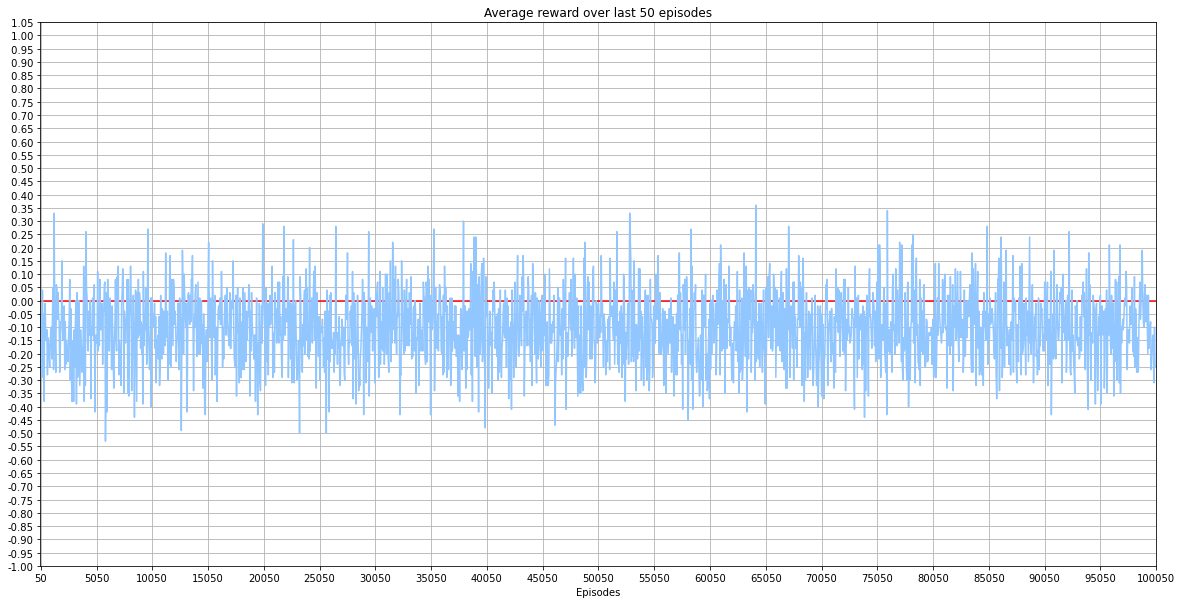

In [91]:
plot_reward_time_series(range(COLLECT_EVERY,EPISODES+1,COLLECT_EVERY),results);

In [92]:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    2000.000000
mean       -0.105565
std         0.138486
min        -0.530000
25%        -0.200000
50%        -0.110000
75%        -0.010000
max         0.360000
dtype: float64

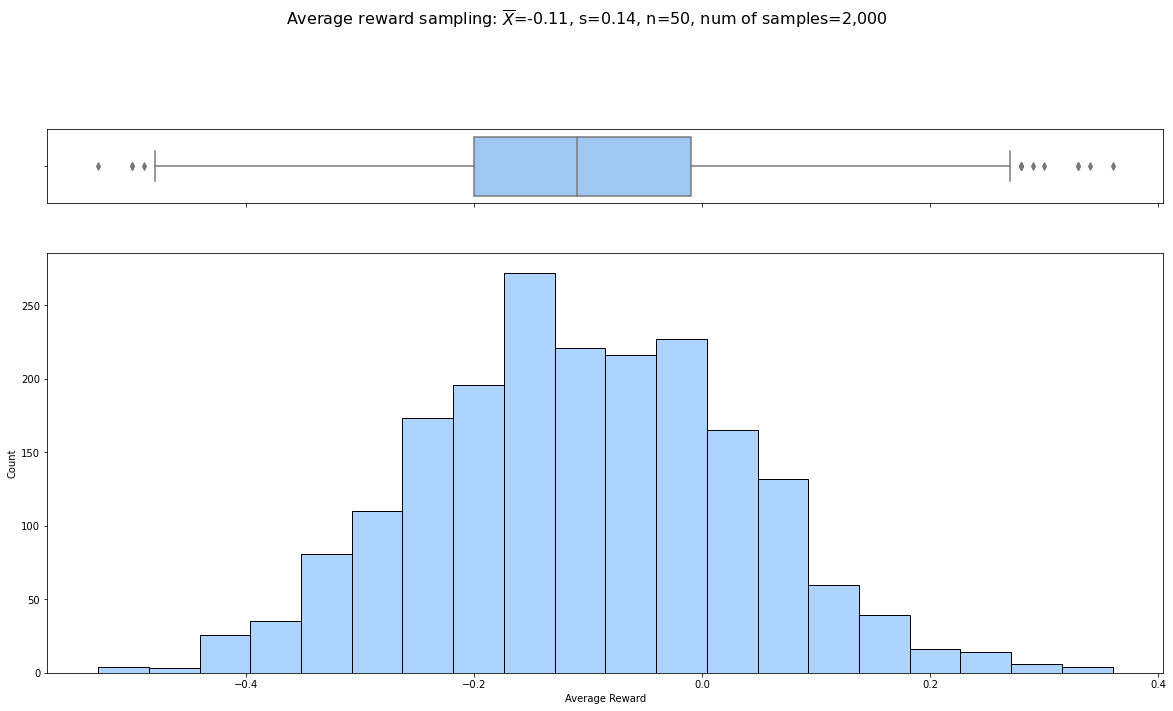

In [94]:
plot_density(runs);

In [96]:
#Error!!!!!!!
stochastic_agent.num_executed_episodes

95273